In [1]:
#Modules jpy
import matplotlib.colors as colors
import matplotlib.image as mplimg
import matplotlib.pyplot as plt
from termcolor import colored
from os.path import join
from glob import iglob
import pandas as pd
import numpy as np
import subprocess
import snappy
from zipfile import ZipFile
pd.options.display.max_colwidth = 80
#https://www.youtube.com/watch?v=PiU68g3WRIY
#https://github.com/techforspace/sentinel/blob/master/SNAP_MERIS_Tutorial/SNAP_MERIS_tutorial.ipynb
#https://senbox.atlassian.net/wiki/spaces/SNAP/pages/50855941/Configure+Python+to+use+the+SNAP-Python+snappy+interface+SNAP+versions+9

In [2]:
def output_view(product,band,min_value_VV,max_value_VV,min_value_VH,max_value_VH,title="band"):
#def output_view(product,band,title):    
    band_data_list = []
    #min_value=[]
    #max_value=[]

    for i in band:
        band=product.getBand(str(i))
        w = band.getRasterWidth()
        h = band.getRasterHeight()
        band_data = np.zeros(w*h,np.float32)
        band.readPixels(0,0,w,h,band_data)
        band_data.shape=h,w
        print(np.min(band_data))
        print(np.max(band_data))
        band_data_list.append(band_data)
        
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,16))
    ax1.imshow(band_data_list[0],cmap="gray",vmin=min_value_VV, vmax=max_value_VV)
    ax1.set_title(title,fontsize=40,color="red")
    ax2.imshow(band_data_list[1],cmap="gray",vmin=min_value_VH, vmax=max_value_VH)
    ax2.set_title(output_bands[1])
    
    for ax in fig.get_axes():
        ax.label_outer()

In [3]:
#Snappy read-subset-apply orbit file- Thermal Noise Removal-calibration-speckle Filtering-terrain correction

print(subprocess.Popen(["gpt","-h","ThermalNoiseRemoval"], stdout=subprocess.PIPE, universal_newlines=True).communicate()[0])


Usage:
  gpt ThermalNoiseRemoval [options] 

Description:
  Removes thermal noise from products


Source Options:
  -SsourceProduct=<file>    Sets source 'sourceProduct' to <filepath>.
                            This is a mandatory source.

Parameter Options:
  -PoutputNoise=<boolean>                               Output noise
                                                        Default value is 'false'.
  -PreIntroduceThermalNoise=<boolean>                   Re-introduce thermal noise
                                                        Default value is 'false'.
  -PremoveThermalNoise=<boolean>                        Remove thermal noise
                                                        Default value is 'true'.
  -PselectedPolarisations=<string,string,string,...>    The list of polarisations

Graph XML Format:
  <graph id="someGraphId">
    <version>1.0</version>
    <node id="someNodeId">
      <operator>ThermalNoiseRemoval</operator>
      <sources>
        <sourceProdu

In [5]:
#Read
product_path="E:\INPUT_radar_images"
input_S1_files = sorted(list(iglob(join(product_path,"**","*S1*.zip"),recursive=True)))

name,sensing_mode,product_type,polarization,height,width,band_names =([] for i in range(7))

for i in input_S1_files:
    sensing_mode.append(i.split("_")[3])
    product_type.append(i.split("_")[4])
    polarization.append(i.split("_")[-6])
    
    s1_read = snappy.ProductIO.readProduct(i)
    name.append(s1_read.getName())
    height.append(s1_read.getSceneRasterHeight())
    width.append(s1_read.getSceneRasterWidth())
    band_names.append(s1_read.getBandNames())
    
df_s1_read = pd.DataFrame({"Name":name,"Sensing mode":sensing_mode,"Product Type":product_type,"Polarization": polarization,"Height": height,"Width":width,"Band Names":band_names})
display(df_s1_read)

#with ZipFile(input_S1_files[0],"r") as qck_look:
    #qck_look=qck_look.open(name[0]+".SAFE/preview/quick-look.png")
    #img =mplimg.imread(qck_look)
    #plt.figure(figsize=(15,15))
    #plt.title("Quicklook visualization - " +name[0] + "\n")
    #plt.axis("off")
    #plt.imshow(img)

,Name,Sensing mode,Product Type,Polarization,Height,Width,Band Names
0,S1A_IW_GRDH_1SDV_20220202T233358_20220202T233427_041740_04F78F_1A96,IW,GRDH,1SDV,19552,25324,"[Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV]"
1,S1A_IW_GRDH_1SDV_20220202T233427_20220202T233501_041740_04F78F_9973,IW,GRDH,1SDV,22815,25312,"[Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV]"


[Ljava.lang.String;@740b9a50
12.0
962.0
7.0
110.0


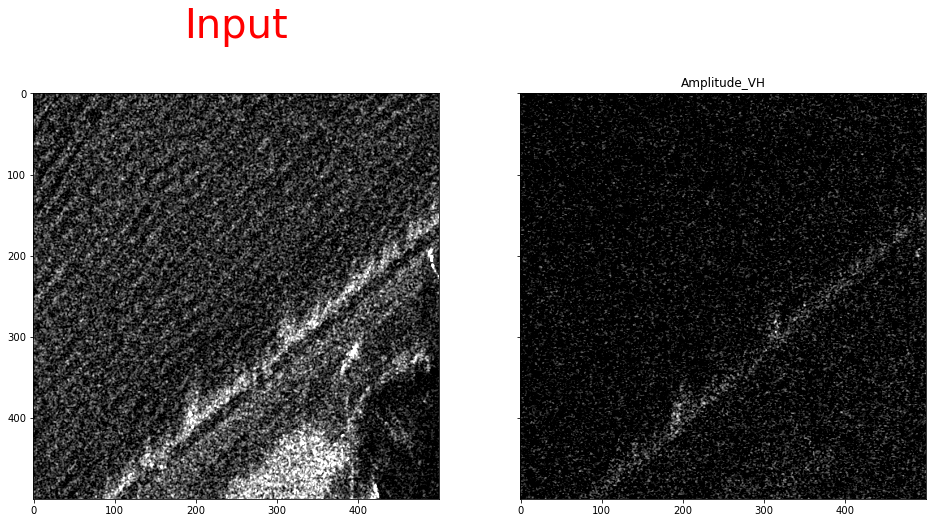

In [6]:
#Subset : reducir el tiempo de procesamiento

x,y,width,heigth = 8000,8000,500,500

parameters=snappy.HashMap()
parameters.put("copyMetadata",True)
parameters.put("region","%s,%s,%s,%s" % (x,y,width,heigth))
subset = snappy.GPF.createProduct("Subset",parameters,s1_read)
list(subset.getBandNames())
print(subset.getBandNames())
output_bands = ['Amplitude_VV','Amplitude_VH']
output_view(subset,output_bands,50,150,40,100,"Input\n")
#output_view(subset,output_bands,"Input")

Orbit updated succesfully
12.0
962.0
7.0
110.0


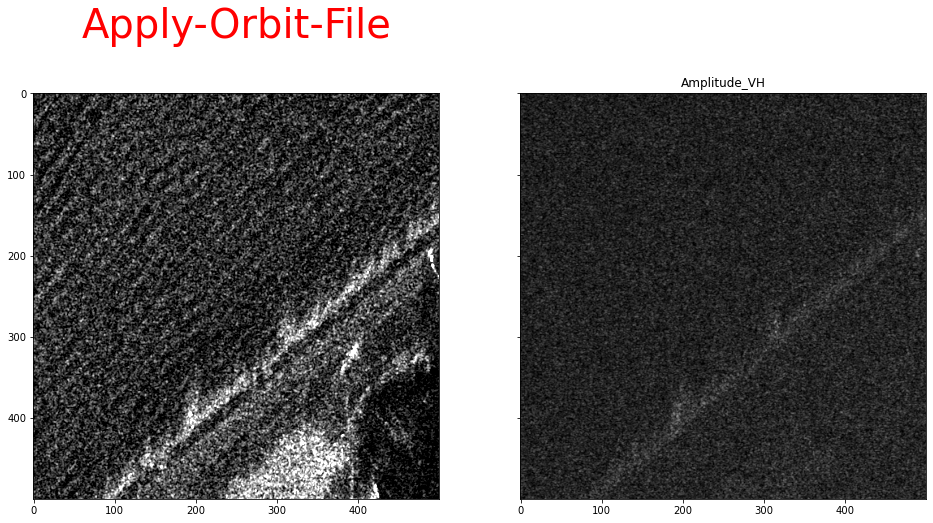

In [7]:
#Apply orbit file: las orbitas no son muy precisas de los productos generados hasta 2 semanas despues
parameters=snappy.HashMap()
parameters.put("Apply-Orbit-File",True)
apply_orbit = snappy.GPF.createProduct("Apply-Orbit-File",parameters,subset)
#apply_orbit = snappy.GPF.createProduct("Apply-Orbit-File",parameters,s1_read)
print(colored("Orbit updated succesfully","green"))

output_bands = ['Amplitude_VV','Amplitude_VH']
output_view(apply_orbit,output_bands,50,150,20,160,"Apply-Orbit-File\n")



1e-05
923937.5
1e-05
10537.847


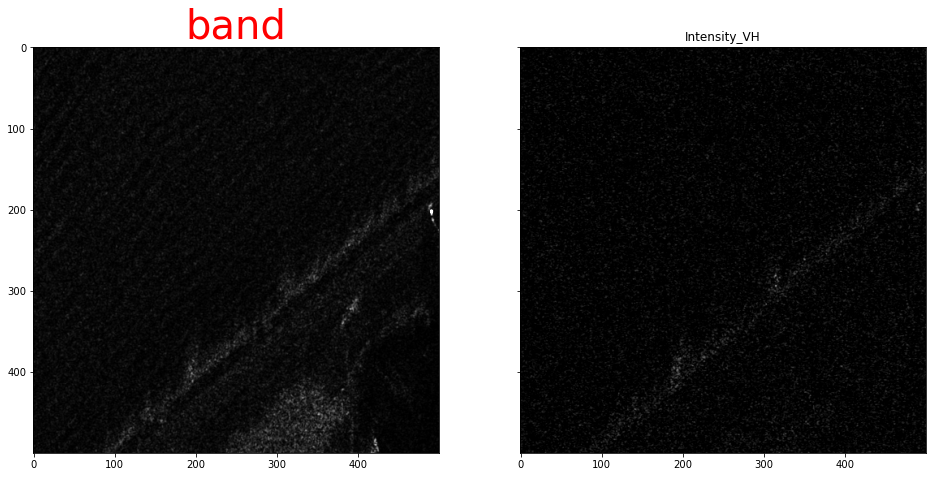

In [8]:
#Thermal Noise Removal: la energía generada por el propio receptor
parameters=snappy.HashMap()
parameters.put("removeThermalNoise",True)
thermal_noise = snappy.GPF.createProduct("ThermalNoiseRemoval",parameters,apply_orbit)

output_bands = ["Intensity_VV","Intensity_VH"]
output_view(thermal_noise,output_bands,0.02,99376.52,0.27,18471.83)

0.00037699295
2.4365535
0.00012840785
0.031772677


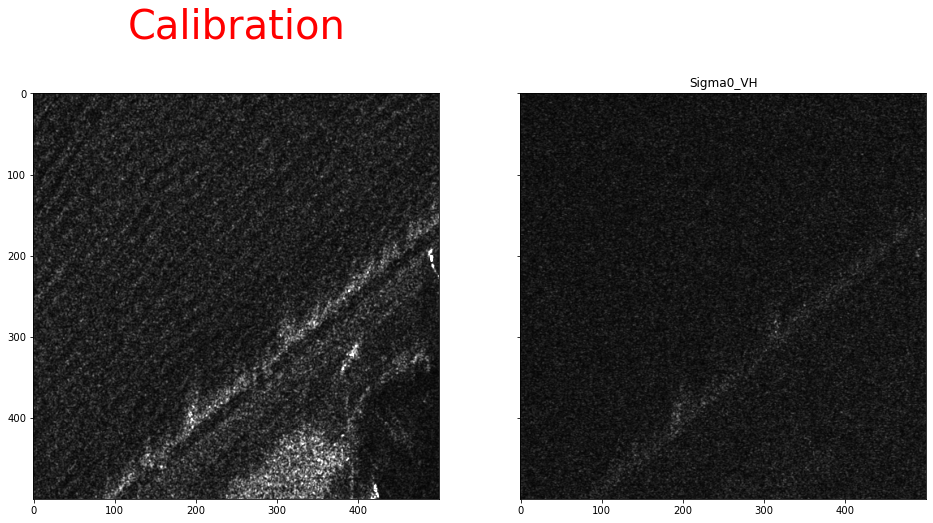

In [9]:
#Radiometric Calibration: Para que los pixeles esten relacionados directamente con los valores de retrodispersion. (cuantitativo-si no se calibra es suficiente de forma cualitativa)
parameters=snappy.HashMap()
parameters.put("outputSigmaBand",True)
parameters.put("sourceBands","Intensity_VH,Intensity_VV")
parameters.put("selectedPolarisations","VH,VV")
parameters.put("outputImageScaleInDb",False)
#calibrated = snappy.GPF.createProduct("Calibration",parameters,thermal_noise)
calibrated = snappy.GPF.createProduct("Calibration",parameters,apply_orbit)

output_bands = ["Sigma0_VV","Sigma0_VH"]
output_view(calibrated,output_bands,0.00,0.1,0.00,0.05,"Calibration\n")


0.0023146681
1.1974573
0.0011004783
0.020578733


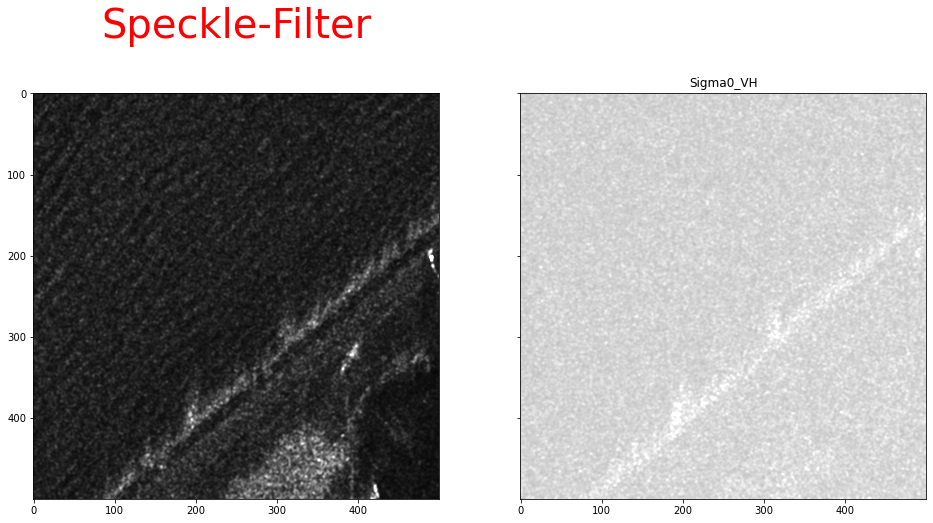

In [10]:
#Speckle filter  compesar las idstorciones geometricas al proyectar la imagen en un sistem geografico
proj = ""

parameters = snappy.HashMap()
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', 3)
parameters.put('filterSizeY', 3)
SF = snappy.GPF.createProduct('Speckle-Filter', parameters, calibrated )

#terrain_correction = snappy.GPF.createProduct("Terrain-Correction",parameters,calibrated)

output_bands = ["Sigma0_VV","Sigma0_VH"]
output_view(SF,output_bands,0,0.1,-0.025,0.01,"Speckle-Filter\n")

0.0
1.1007209
0.0
0.019457571


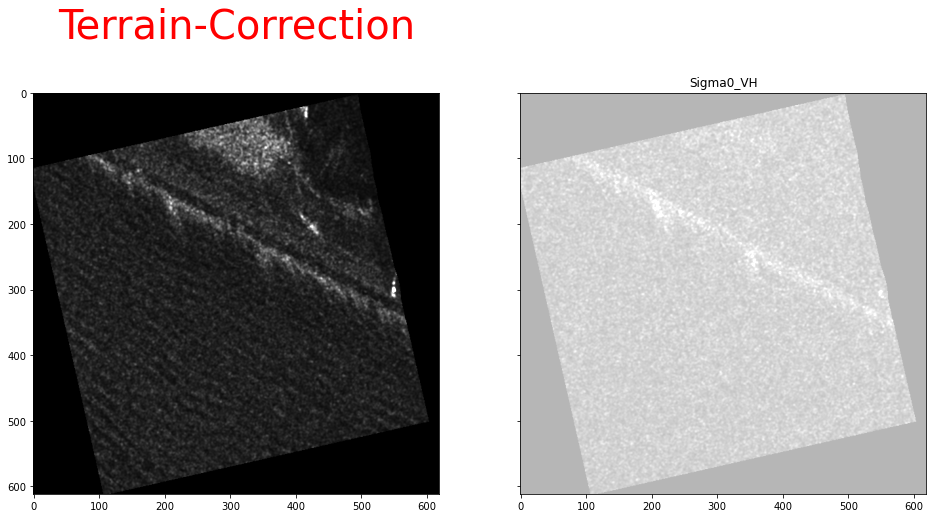

In [11]:
#Terrain Correction:  compesar las idstorciones geometricas al proyectar la imagen en un sistem geografico
proj = ""

parameters=snappy.HashMap()
parameters.put("demName","SRTM 3Sec")
parameters.put("imgResamplingMethod","BILINEAR_INTERPOLATION")
parameters.put("pixelSpacingInMeter",10.0)
parameters.put("mapProjection",proj)
parameters.put("nodataValueAtSea",False)
parameters.put("saveSelectedSourceBand",True)
parameters.put("outputImageScaleInDb",True)
terrain_correction = snappy.GPF.createProduct("Terrain-Correction",parameters,SF)

output_bands = ["Sigma0_VV","Sigma0_VH"]
output_view(terrain_correction,output_bands,0,0.1,-0.025,0.01,"Terrain-Correction\n")

In [ ]:
#Save

outpath_name= ""

snappy.ProductIO.writeProduct(terrain_correction,outpath_name,"GeoTIFF")
print(colored("Product succesfully saved in: ", "green"),outhpath_name)

In [ ]:
output_bands = ['Amplitude_VV','Amplitude_VH']
for i in output_bands:
    print(i)

In [ ]:
import datetime
import time
from snappy import ProductIO
from snappy import HashMap
import os, gc
from snappy import GPF

def do_apply_orbit_file(source):
    print('\tApply orbit file...')
    parameters = HashMap()
    parameters.put('Apply-Orbit-File', True)
    output = GPF.createProduct('Apply-Orbit-File', parameters, source)
    return output

def do_thermal_noise_removal(source):
    print('\tThermal noise removal...')
    parameters = HashMap()
    parameters.put('removeThermalNoise', True)
    output = GPF.createProduct('ThermalNoiseRemoval', parameters, source)
    return output

def do_calibration(source, polarization, pols):
    print('\tCalibration...')
    parameters = HashMap()
    parameters.put('outputSigmaBand', True)
    if polarization == 'DH':
        parameters.put('sourceBands', 'Intensity_HH,Intensity_HV')
    elif polarization == 'DV':
        parameters.put('sourceBands', 'Intensity_VH,Intensity_VV')
    elif polarization == 'SH' or polarization == 'HH':
        parameters.put('sourceBands', 'Intensity_HH')
    elif polarization == 'SV':
        parameters.put('sourceBands', 'Intensity_VV')
    else:
        print("different polarization!")
    parameters.put('selectedPolarisations', pols)
    parameters.put('outputImageScaleInDb', False)
    output = GPF.createProduct("Calibration", parameters, source)
    return output

def do_speckle_filtering(source):
    print('\tSpeckle filtering...')
    parameters = HashMap()
    parameters.put('filter', 'Lee')
    parameters.put('filterSizeX', 5)
    parameters.put('filterSizeY', 5)
    output = GPF.createProduct('Speckle-Filter', parameters, source)
    return output

def do_terrain_correction(source, proj, downsample):
    print('\tTerrain correction...')
    parameters = HashMap()
    parameters.put('demName', 'GETASSE30')
    parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
    parameters.put('mapProjection', proj)       # comment this line if no need to convert to UTM/WGS84, default is WGS84
    parameters.put('saveProjectedLocalIncidenceAngle', True)
    parameters.put('saveSelectedSourceBand', True)
    while downsample == 1:                      # downsample: 1 -- need downsample to 40m, 0 -- no need to downsample
        parameters.put('pixelSpacingInMeter', 40.0)
        break
    output = GPF.createProduct('Terrain-Correction', parameters, source)
    return output

def do_subset(source, wkt):
    print('\tSubsetting...')
    parameters = HashMap()
    parameters.put('geoRegion', wkt)
    output = GPF.createProduct('Subset', parameters, source)
    return output

def main():
    ## All Sentinel-1 data sub folders are located within a super folder (make sure the data is already unzipped and each sub folder name ends with '.SAFE'):
    path = r'data\s1_images'
    outpath = r'data\s1_preprocessed'
    if not os.path.exists(outpath):
        os.makedirs(outpath)
    ## well-known-text (WKT) file for subsetting (can be obtained from SNAP by drawing a polygon)
    wkt = 'POLYGON ((-157.79579162597656 71.36872100830078, -155.4447021484375 71.36872100830078, \
    -155.4447021484375 70.60020446777344, -157.79579162597656 70.60020446777344, -157.79579162597656 71.36872100830078))'
    ## UTM projection parameters
    proj = '''PROJCS["UTM Zone 4 / World Geodetic System 1984",GEOGCS["World Geodetic System 1984",DATUM["World Geodetic System 1984",SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]],UNIT["degree", 0.017453292519943295],AXIS["Geodetic longitude", EAST],AXIS["Geodetic latitude", NORTH]],PROJECTION["Transverse_Mercator"],PARAMETER["central_meridian", -159.0],PARAMETER["latitude_of_origin", 0.0],PARAMETER["scale_factor", 0.9996],PARAMETER["false_easting", 500000.0],PARAMETER["false_northing", 0.0],UNIT["m", 1.0],AXIS["Easting", EAST],AXIS["Northing", NORTH]]'''

    for folder in os.listdir(path):
        gc.enable()
        gc.collect()
        sentinel_1 = ProductIO.readProduct(path + "\\" + folder + "\\manifest.safe")
        print(sentinel_1)

        loopstarttime=str(datetime.datetime.now())
        print('Start time:', loopstarttime)
        start_time = time.time()

        ## Extract mode, product type, and polarizations from filename
        modestamp = folder.split("_")[1]
        productstamp = folder.split("_")[2]
        polstamp = folder.split("_")[3]

        polarization = polstamp[2:4]
        if polarization == 'DV':
            pols = 'VH,VV'
        elif polarization == 'DH':
            pols = 'HH,HV'
        elif polarization == 'SH' or polarization == 'HH':
            pols = 'HH'
        elif polarization == 'SV':
            pols = 'VV'
        else:
            print("Polarization error!")

        ## Start preprocessing:
        applyorbit = do_apply_orbit_file(sentinel_1)
        thermaremoved = do_thermal_noise_removal(applyorbit)
        calibrated = do_calibration(thermaremoved, polarization, pols)
        down_filtered = do_speckle_filtering(calibrated)
        del applyorbit
        del thermaremoved
        del calibrated
        ## IW images are downsampled from 10m to 40m (the same resolution as EW images).
        if (modestamp == 'IW' and productstamp == 'GRDH') or (modestamp == 'EW' and productstamp == 'GRDH'):
            down_tercorrected = do_terrain_correction(down_filtered, proj, 1)
            down_subset = do_subset(down_tercorrected, wkt)
            del down_filtered
            del down_tercorrected
        elif modestamp == 'EW' and productstamp == 'GRDM':
            tercorrected = do_terrain_correction(down_filtered, proj, 0)
            subset = do_subset(tercorrected, wkt)
            del down_filtered
            del tercorrected
        else:
            print("Different spatial resolution is found.")

        down = 1
        try: down_subset
        except NameError:
            down = None
        if down is None:
            print("Writing...")
            ProductIO.writeProduct(subset, outpath + '\\' + folder[:-5], 'GeoTIFF')
            del subset
        elif down == 1:
            print("Writing undersampled image...")
            ProductIO.writeProduct(down_subset, outpath + '\\' + folder[:-5] + '_40', 'GeoTIFF')
            del down_subset
        else:
            print("Error.")

        print('Done.')
        sentinel_1.dispose()
        sentinel_1.closeIO()
        print("--- %s seconds ---" % (time.time() - start_time))

if __name__== "__main__":
    main()

In [ ]:
import sys, csv
import os, os.path
import tempfile, shutil
import re

import base64
import time
import getpass
import ssl
import signal
import socket

import xml.etree.ElementTree as ET

#############
# This next block is a bunch of Python 2/3 compatability

try:
   # Python 2.x Libs
   from urllib2 import build_opener, install_opener, Request, urlopen, HTTPError
   from urllib2 import URLError, HTTPSHandler,  HTTPHandler, HTTPCookieProcessor

   from cookielib import MozillaCookieJar
   from StringIO import StringIO

except ImportError as e:

   # Python 3.x Libs
   from urllib.request import build_opener, install_opener, Request, urlopen
   from urllib.request import HTTPHandler, HTTPSHandler, HTTPCookieProcessor
   from urllib.error import HTTPError, URLError

   from http.cookiejar import MozillaCookieJar
   from io import StringIO

###
# Global variables intended for cross-thread modification
abort = False

###
# A routine that handles trapped signals
def signal_handler(sig, frame):
    global abort
    sys.stderr.output("\n > Caught Signal. Exiting!\n")
    abort = True # necessary to cause the program to stop
    raise SystemExit  # this will only abort the thread that the ctrl+c was caught in

class bulk_downloader:
    def __init__(self):
        # List of files to download
        self.files = [ "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180504T104624_20180504T104649_010770_013AEE_5CC6.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180422T104623_20180422T104648_010595_01354A_D05E.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180410T104623_20180410T104648_010420_012FB5_20C8.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180329T104622_20180329T104647_010245_0129FF_A127.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180317T104622_20180317T104647_010070_012455_D02E.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180305T104622_20180305T104647_009895_011E91_7D52.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180221T104622_20180221T104647_009720_0118BB_AD61.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180209T104622_20180209T104647_009545_011301_AAC1.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180128T104622_20180128T104647_009370_010D3E_8EDC.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180116T104623_20180116T104648_009195_010785_E89A.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20180104T104623_20180104T104648_009020_0101D3_D8C2.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20191107T104638_20191107T104703_018820_0237C9_958D.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20191026T104638_20191026T104703_018645_02322A_F344.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20191014T104638_20191014T104703_018470_022CCE_517E.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20191002T104638_20191002T104703_018295_02275E_C1CA.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20190920T104638_20190920T104703_018120_0221EE_31C8.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20190908T104637_20190908T104702_017945_021C7E_A8AB.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20201231T104642_20201231T104707_024945_02F7F9_3665.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20210112T104642_20210112T104707_025120_02FD9A_E560.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20201219T104643_20201219T104708_024770_02F256_EE1F.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20210124T104641_20210124T104706_025295_030329_962A.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20210217T104641_20210217T104706_025645_030E89_83F2.zip",
                       "https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20210301T104640_20210301T104705_025820_03143D_676D.zip" ]

        # Local stash of cookies so we don't always have to ask
        self.cookie_jar_path = os.path.join( os.path.expanduser('~'), ".bulk_download_cookiejar.txt")
        self.cookie_jar = None

        self.asf_urs4 = { 'url': 'https://urs.earthdata.nasa.gov/oauth/authorize',
                 'client': 'BO_n7nTIlMljdvU6kRRB3g',
                 'redir': 'https://auth.asf.alaska.edu/login'}

        # Make sure we can write it our current directory
        if os.access(os.getcwd(), os.W_OK) is False:
            print ("WARNING: Cannot write to current path! Check permissions for {0}".format(os.getcwd()))
            exit(-1)

        # For SSL
        self.context = {}

        # Check if user handed in a Metalink or CSV:
        if len(sys.argv) > 0:
            download_files = []
            input_files = []
            for arg in sys.argv[1:]:
                if arg == '--insecure':
                    try:
                        ctx = ssl.create_default_context()
                        ctx.check_hostname = False
                        ctx.verify_mode = ssl.CERT_NONE
                        self.context['context'] = ctx
                    except AttributeError:
                        # Python 2.6 won't complain about SSL Validation
                        pass

                elif arg.endswith('.metalink') or arg.endswith('.csv'):
                    if os.path.isfile( arg ):
                        input_files.append( arg )
                        if arg.endswith('.metalink'):
                            new_files = self.process_metalink(arg)
                        else:
                            new_files = self.process_csv(arg)
                        if new_files is not None:
                            for file_url in (new_files):
                                download_files.append( file_url )
                    else:
                         print (" > I cannot find the input file you specified: {0}".format(arg))
                else:
                    print (" > Command line argument '{0}' makes no sense, ignoring.".format(arg))

            if len(input_files) > 0:
                if len(download_files) > 0:
                    print (" > Processing {0} downloads from {1} input files. ".format(len(download_files), len(input_files)))
                    self.files = download_files
                else:
                    print (" > I see you asked me to download files from {0} input files, but they had no downloads!".format(len(input_files)))
                    print (" > I'm super confused and exiting.")
                    exit(-1)

        # Make sure cookie_jar is good to go!
        self.get_cookie()

         # summary
        self.total_bytes = 0
        self.total_time = 0
        self.cnt = 0
        self.success = []
        self.failed = []
        self.skipped = []


    # Get and validate a cookie
    def get_cookie(self):
       if os.path.isfile(self.cookie_jar_path):
          self.cookie_jar = MozillaCookieJar()
          self.cookie_jar.load(self.cookie_jar_path)

          # make sure cookie is still valid
          if self.check_cookie():
             print(" > Reusing previous cookie jar.")
             return True
          else:
             print(" > Could not validate old cookie Jar")

       # We don't have a valid cookie, prompt user or creds
       print ("No existing URS cookie found, please enter Earthdata username & password:")
       print ("(Credentials will not be stored, saved or logged anywhere)")

       # Keep trying 'till user gets the right U:P
       while self.check_cookie() is False:
          self.get_new_cookie()

       return True

    # Validate cookie before we begin
    def check_cookie(self):

       if self.cookie_jar is None:
          print (" > Cookiejar is bunk: {0}".format(self.cookie_jar))
          return False

       # File we know is valid, used to validate cookie
       file_check = 'https://urs.earthdata.nasa.gov/profile'

       # Apply custom Redirect Hanlder
       opener = build_opener(HTTPCookieProcessor(self.cookie_jar), HTTPHandler(), HTTPSHandler(**self.context))
       install_opener(opener)

       # Attempt a HEAD request
       request = Request(file_check)
       request.get_method = lambda : 'HEAD'
       try:
          print (" > attempting to download {0}".format(file_check))
          response = urlopen(request, timeout=30)
          resp_code = response.getcode()
          # Make sure we're logged in
          if not self.check_cookie_is_logged_in(self.cookie_jar):
             return False

          # Save cookiejar
          self.cookie_jar.save(self.cookie_jar_path)

       except HTTPError:
          # If we ge this error, again, it likely means the user has not agreed to current EULA
          print ("\nIMPORTANT: ")
          print ("Your user appears to lack permissions to download data from the ASF Datapool.")
          print ("\n\nNew users: you must first log into Vertex and accept the EULA. In addition, your Study Area must be set at Earthdata https://urs.earthdata.nasa.gov")
          exit(-1)

       # This return codes indicate the USER has not been approved to download the data
       if resp_code in (300, 301, 302, 303):
          try:
             redir_url = response.info().getheader('Location')
          except AttributeError:
             redir_url = response.getheader('Location')

          #Funky Test env:
          if ("vertex-retired.daac.asf.alaska.edu" in redir_url and "test" in self.asf_urs4['redir']):
             print ("Cough, cough. It's dusty in this test env!")
             return True

          print ("Redirect ({0}) occured, invalid cookie value!".format(resp_code))
          return False

       # These are successes!
       if resp_code in (200, 307):
          return True

       return False

    def get_new_cookie(self):
       # Start by prompting user to input their credentials

       # Another Python2/3 workaround
       try:
          new_username = raw_input("Username: ")
       except NameError:
          new_username = input("Username: ")
       new_password = getpass.getpass(prompt="Password (will not be displayed): ")

       # Build URS4 Cookie request
       auth_cookie_url = self.asf_urs4['url'] + '?client_id=' + self.asf_urs4['client'] + '&redirect_uri=' + self.asf_urs4['redir'] + '&response_type=code&state='

       try:
          #python2
          user_pass = base64.b64encode (bytes(new_username+":"+new_password))
       except TypeError:
          #python3
          user_pass = base64.b64encode (bytes(new_username+":"+new_password, "utf-8"))
          user_pass = user_pass.decode("utf-8")

       # Authenticate against URS, grab all the cookies
       self.cookie_jar = MozillaCookieJar()
       opener = build_opener(HTTPCookieProcessor(self.cookie_jar), HTTPHandler(), HTTPSHandler(**self.context))
       request = Request(auth_cookie_url, headers={"Authorization": "Basic {0}".format(user_pass)})

       # Watch out cookie rejection!
       try:
          response = opener.open(request)
       except HTTPError as e:
          if "WWW-Authenticate" in e.headers and "Please enter your Earthdata Login credentials" in e.headers["WWW-Authenticate"]:
             print (" > Username and Password combo was not successful. Please try again.")
             return False
          else:
             # If an error happens here, the user most likely has not confirmed EULA.
             print ("\nIMPORTANT: There was an error obtaining a download cookie!")
             print ("Your user appears to lack permission to download data from the ASF Datapool.")
             print ("\n\nNew users: you must first log into Vertex and accept the EULA. In addition, your Study Area must be set at Earthdata https://urs.earthdata.nasa.gov")
             exit(-1)
       except URLError as e:
          print ("\nIMPORTANT: There was a problem communicating with URS, unable to obtain cookie. ")
          print ("Try cookie generation later.")
          exit(-1)

       # Did we get a cookie?
       if self.check_cookie_is_logged_in(self.cookie_jar):
          #COOKIE SUCCESS!
          self.cookie_jar.save(self.cookie_jar_path)
          return True

       # if we aren't successful generating the cookie, nothing will work. Stop here!
       print ("WARNING: Could not generate new cookie! Cannot proceed. Please try Username and Password again.")
       print ("Response was {0}.".format(response.getcode()))
       print ("\n\nNew users: you must first log into Vertex and accept the EULA. In addition, your Study Area must be set at Earthdata https://urs.earthdata.nasa.gov")
       exit(-1)

    # make sure we're logged into URS
    def check_cookie_is_logged_in(self, cj):
       for cookie in cj:
          if cookie.name == 'urs_user_already_logged':
              # Only get this cookie if we logged in successfully!
              return True

       return False


    # Download the file
    def download_file_with_cookiejar(self, url, file_count, total, recursion=False):
       # see if we've already download this file and if it is that it is the correct size
       download_file = os.path.basename(url).split('?')[0]
       if os.path.isfile(download_file):
          try:
             request = Request(url)
             request.get_method = lambda : 'HEAD'
             response = urlopen(request, timeout=30)
             remote_size = self.get_total_size(response)
             # Check that we were able to derive a size.
             if remote_size:
                 local_size = os.path.getsize(download_file)
                 if remote_size < (local_size+(local_size*.01)) and remote_size > (local_size-(local_size*.01)):
                     print (" > Download file {0} exists! \n > Skipping download of {1}. ".format(download_file, url))
                     return None,None
                 #partial file size wasn't full file size, lets blow away the chunk and start again
                 print (" > Found {0} but it wasn't fully downloaded. Removing file and downloading again.".format(download_file))
                 os.remove(download_file)

          except ssl.CertificateError as e:
             print (" > ERROR: {0}".format(e))
             print (" > Could not validate SSL Cert. You may be able to overcome this using the --insecure flag")
             return False,None

          except HTTPError as e:
             if e.code == 401:
                 print (" > IMPORTANT: Your user may not have permission to download this type of data!")
             else:
                 print (" > Unknown Error, Could not get file HEAD: {0}".format(e))

          except URLError as e:
             print ("URL Error (from HEAD): {0}, {1}".format( e.reason, url))
             if "ssl.c" in "{0}".format(e.reason):
                 print ("IMPORTANT: Remote location may not be accepting your SSL configuration. This is a terminal error.")
             return False,None

       # attempt https connection
       try:
          request = Request(url)
          response = urlopen(request, timeout=30)

          # Watch for redirect
          if response.geturl() != url:

             # See if we were redirect BACK to URS for re-auth.
             if 'https://urs.earthdata.nasa.gov/oauth/authorize' in response.geturl():

                 if recursion:
                     print (" > Entering seemingly endless auth loop. Aborting. ")
                     return False, None

                 # make this easier. If there is no app_type=401, add it
                 new_auth_url = response.geturl()
                 if "app_type" not in new_auth_url:
                     new_auth_url += "&app_type=401"

                 print (" > While attempting to download {0}....".format(url))
                 print (" > Need to obtain new cookie from {0}".format(new_auth_url))
                 old_cookies = [cookie.name for cookie in self.cookie_jar]
                 opener = build_opener(HTTPCookieProcessor(self.cookie_jar), HTTPHandler(), HTTPSHandler(**self.context))
                 request = Request(new_auth_url)
                 try:
                     response = opener.open(request)
                     for cookie in self.cookie_jar:
                         if cookie.name not in old_cookies:
                              print (" > Saved new cookie: {0}".format(cookie.name))

                              # A little hack to save session cookies
                              if cookie.discard:
                                   cookie.expires = int(time.time()) + 60*60*24*30
                                   print (" > Saving session Cookie that should have been discarded! ")

                     self.cookie_jar.save(self.cookie_jar_path, ignore_discard=True, ignore_expires=True)
                 except HTTPError as e:
                     print ("HTTP Error: {0}, {1}".format( e.code, url))
                     return False,None

                 # Okay, now we have more cookies! Lets try again, recursively!
                 print (" > Attempting download again with new cookies!")
                 return self.download_file_with_cookiejar(url, file_count, total, recursion=True)

             print (" > 'Temporary' Redirect download @ Remote archive:\n > {0}".format(response.geturl()))

          # seems to be working
          print ("({0}/{1}) Downloading {2}".format(file_count, total, url))

          # Open our local file for writing and build status bar
          tf = tempfile.NamedTemporaryFile(mode='w+b', delete=False, dir='.')
          self.chunk_read(response, tf, report_hook=self.chunk_report)

          # Reset download status
          sys.stdout.write('\n')

          tempfile_name = tf.name
          tf.close()

       #handle errors
       except HTTPError as e:
          print ("HTTP Error: {0}, {1}".format( e.code, url))

          if e.code == 401:
             print (" > IMPORTANT: Your user does not have permission to download this type of data!")

          if e.code == 403:
             print (" > Got a 403 Error trying to download this file.  ")
             print (" > You MAY need to log in this app and agree to a EULA. ")

          return False,None

       except URLError as e:
          print ("URL Error (from GET): {0}, {1}, {2}".format(e, e.reason, url))
          if "ssl.c" in "{0}".format(e.reason):
              print ("IMPORTANT: Remote location may not be accepting your SSL configuration. This is a terminal error.")
          return False,None

       except socket.timeout as e:
           print (" > timeout requesting: {0}; {1}".format(url, e))
           return False,None

       except ssl.CertificateError as e:
          print (" > ERROR: {0}".format(e))
          print (" > Could not validate SSL Cert. You may be able to overcome this using the --insecure flag")
          return False,None

       # Return the file size
       shutil.copy(tempfile_name, download_file)
       os.remove(tempfile_name)
       file_size = self.get_total_size(response)
       actual_size = os.path.getsize(download_file)
       if file_size is None:
           # We were unable to calculate file size.
           file_size = actual_size
       return actual_size,file_size

    def get_redirect_url_from_error(self, error):
       find_redirect = re.compile(r"id=\"redir_link\"\s+href=\"(\S+)\"")
       print ("error file was: {}".format(error))
       redirect_url = find_redirect.search(error)
       if redirect_url:
          print("Found: {0}".format(redirect_url.group(0)))
          return (redirect_url.group(0))

       return None


    #  chunk_report taken from http://stackoverflow.com/questions/2028517/python-urllib2-progress-hook
    def chunk_report(self, bytes_so_far, file_size):
       if file_size is not None:
           percent = float(bytes_so_far) / file_size
           percent = round(percent*100, 2)
           sys.stdout.write(" > Downloaded %d of %d bytes (%0.2f%%)\r" %
               (bytes_so_far, file_size, percent))
       else:
           # We couldn't figure out the size.
           sys.stdout.write(" > Downloaded %d of unknown Size\r" % (bytes_so_far))

    #  chunk_read modified from http://stackoverflow.com/questions/2028517/python-urllib2-progress-hook
    def chunk_read(self, response, local_file, chunk_size=8192, report_hook=None):
       file_size = self.get_total_size(response)
       bytes_so_far = 0

       while 1:
          try:
             chunk = response.read(chunk_size)
          except:
             sys.stdout.write("\n > There was an error reading data. \n")
             break

          try:
             local_file.write(chunk)
          except TypeError:
             local_file.write(chunk.decode(local_file.encoding))
          bytes_so_far += len(chunk)

          if not chunk:
             break

          if report_hook:
             report_hook(bytes_so_far, file_size)

       return bytes_so_far

    def get_total_size(self, response):
       try:
          file_size = response.info().getheader('Content-Length').strip()
       except AttributeError:
          try:
             file_size = response.getheader('Content-Length').strip()
          except AttributeError:
             print ("> Problem getting size")
             return None

       return int(file_size)


    # Get download urls from a metalink file
    def process_metalink(self, ml_file):
       print ("Processing metalink file: {0}".format(ml_file))
       with open(ml_file, 'r') as ml:
          xml = ml.read()

       # Hack to remove annoying namespace
       it = ET.iterparse(StringIO(xml))
       for _, el in it:
          if '}' in el.tag:
             el.tag = el.tag.split('}', 1)[1]  # strip all namespaces
       root = it.root

       dl_urls = []
       ml_files = root.find('files')
       for dl in ml_files:
          dl_urls.append(dl.find('resources').find('url').text)

       if len(dl_urls) > 0:
          return dl_urls
       else:
          return None

    # Get download urls from a csv file
    def process_csv(self, csv_file):
       print ("Processing csv file: {0}".format(csv_file))

       dl_urls = []
       with open(csv_file, 'r') as csvf:
          try:
             csvr = csv.DictReader(csvf)
             for row in csvr:
                dl_urls.append(row['URL'])
          except csv.Error as e:
             print ("WARNING: Could not parse file %s, line %d: %s. Skipping." % (csv_file, csvr.line_num, e))
             return None
          except KeyError as e:
             print ("WARNING: Could not find URL column in file %s. Skipping." % (csv_file))

       if len(dl_urls) > 0:
          return dl_urls
       else:
          return None

    # Download all the files in the list
    def download_files(self):
        for file_name in self.files:

            # make sure we haven't ctrl+c'd or some other abort trap
            if abort == True:
              raise SystemExit

            # download counter
            self.cnt += 1

            # set a timer
            start = time.time()

            # run download
            size,total_size = self.download_file_with_cookiejar(file_name, self.cnt, len(self.files))

            # calculte rate
            end = time.time()

            # stats:
            if size is None:
                self.skipped.append(file_name)
            # Check to see that the download didn't error and is the correct size
            elif size is not False and (total_size < (size+(size*.01)) and total_size > (size-(size*.01))):
                # Download was good!
                elapsed = end - start
                elapsed = 1.0 if elapsed < 1 else elapsed
                rate = (size/1024**2)/elapsed

                print ("Downloaded {0}b in {1:.2f}secs, Average Rate: {2:.2f}MB/sec".format(size, elapsed, rate))

                # add up metrics
                self.total_bytes += size
                self.total_time += elapsed
                self.success.append( {'file':file_name, 'size':size } )

            else:
                print ("There was a problem downloading {0}".format(file_name))
                self.failed.append(file_name)

    def print_summary(self):
        # Print summary:
        print ("\n\nDownload Summary ")
        print ("--------------------------------------------------------------------------------")
        print ("  Successes: {0} files, {1} bytes ".format(len(self.success), self.total_bytes))
        for success_file in self.success:
           print ("           - {0}  {1:.2f}MB".format(success_file['file'],(success_file['size']/1024.0**2)))
        if len(self.failed) > 0:
           print ("  Failures: {0} files".format(len(self.failed)))
           for failed_file in self.failed:
              print ("          - {0}".format(failed_file))
        if len(self.skipped) > 0:
           print ("  Skipped: {0} files".format(len(self.skipped)))
           for skipped_file in self.skipped:
              print ("          - {0}".format(skipped_file))
        if len(self.success) > 0:
           print ("  Average Rate: {0:.2f}MB/sec".format( (self.total_bytes/1024.0**2)/self.total_time))
        print ("--------------------------------------------------------------------------------")


if __name__ == "__main__":
    # Setup a signal trap for SIGINT (Ctrl+C)
    signal.signal(signal.SIGINT, signal_handler)

    downloader = bulk_downloader()
    downloader.download_files()
    downloader.print_summary()